In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix as CM,accuracy_score,auc,roc_curve
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,binarize
from pandas_ml import ConfusionMatrix

Using TensorFlow backend.


In [2]:
df=pd.read_csv('Final_feature_set.csv',index_col=['Unnamed: 0'])
df.fillna(value=0,inplace=True)
df=df[df['Age']>=0]
df.head()

df2=df.copy(deep=True)
df2.drop(['User_Id','User_Name_x','Created_At','Language'],axis=1,inplace=True)
df2.set_index(['User_Screen_Name'],inplace=True,drop=True)
df2.Gender=df2.Gender.apply(lambda x: 1 if x=='F' else 0)
df2=df2[df2['Avg Number of Mentions']!='True']

In [3]:
df2.head()

,Followers_Count,Friends_Count,Listed_Count,Favorites_Count,Statuses_Count,Number of Tweets,Avg Number of Mentions,Average Number of Links,Average Number of Words,Acc_Age_Month,Malicious,Age,Gender
User_Screen_Name,,,,,,,,,,,,,
MichaelDeMers4,12,42,0,11,120,113,1.3628318584070795,0.23008849557522126,9.610619469026547,67.746332,0,32.561429,0
vanbastarache,61,223,1,1507,648,611,0.33387888707037644,0.1833060556464812,13.734860883797054,84.591551,0,26.093862,1
leslievanilla,743,414,3,5216,789,229,0.6724890829694323,0.0611353711790393,4.973799126637554,27.153099,1,21.084834,1
EVJ44,187,270,3,8753,605,226,0.6327433628318584,0.584070796460177,10.336283185840708,19.283745,1,20.619374,1
Leah10123,20,253,0,106,141,138,0.5507246376811594,0.8840579710144928,7.195652173913044,81.419931,0,22.270800,1


In [4]:
lst=[]
for col in df2.columns:
    df2[col]=df2[col].astype(float)
    x=df2[col].values
    lst.append((col,np.min(x),np.average(x),np.percentile(x,75),np.max(x)))
stats=pd.DataFrame(lst)
stats.columns=['Feature','Min','Avg','75th Percentile','Max']
stats.set_index(['Feature'],inplace=True,drop=True)
stats

,Min,Avg,75th Percentile,Max
Feature,,,,
Followers_Count,0.000000,644.417041,321.000000,817098.000000
Friends_Count,0.000000,426.436069,421.000000,93199.000000
Listed_Count,0.000000,6.774909,3.000000,1628.000000
Favorites_Count,0.000000,1669.205227,983.000000,278227.000000
Statuses_Count,1.000000,3182.170727,2275.000000,440972.000000
Number of Tweets,1.000000,830.481129,1278.000000,3250.000000
Avg Number of Mentions,0.000000,0.653505,0.940806,6.611467
Average Number of Links,0.000000,0.413444,0.664234,2.897898
Average Number of Words,0.052050,10.088319,12.254717,26.000000


In [5]:
nm=df2[df2['Malicious']==0]
m=df2[df2['Malicious']==1]

In [6]:
print("Non Malicious")
lst=[]
for col in nm.columns:
    x=nm[col].values
    lst.append((col,np.min(x),np.average(x),np.percentile(x,75),np.max(x)))
stats=pd.DataFrame(lst)
stats.columns=['Feature','Min','Avg','75th Percentile','Max']
stats.set_index(['Feature'],inplace=True,drop=True)
stats

Non Malicious


,Min,Avg,75th Percentile,Max
Feature,,,,
Followers_Count,0.000000,473.259847,311.000000,373844.000000
Friends_Count,0.000000,405.818789,414.000000,93199.000000
Listed_Count,0.000000,5.675435,3.000000,1628.000000
Favorites_Count,0.000000,1061.975087,772.000000,86143.000000
Statuses_Count,23.000000,2599.771051,1950.000000,440972.000000
Number of Tweets,101.000000,871.580654,1289.000000,3250.000000
Avg Number of Mentions,0.000000,0.595481,0.861386,6.611467
Average Number of Links,0.000000,0.412552,0.689895,2.897898
Average Number of Words,0.052050,9.806365,12.098707,22.321429


In [7]:
print("Malicious")
lst=[]
for col in m.columns:
    x=m[col].values
    lst.append((col,np.min(x),np.average(x),np.percentile(x,75),np.max(x)))
stats=pd.DataFrame(lst)
stats.columns=['Feature','Min','Avg','75th Percentile','Max']
stats.set_index(['Feature'],inplace=True,drop=True)
stats

Malicious


,Min,Avg,75th Percentile,Max
Feature,,,,
Followers_Count,0.000000,1161.124790,371.500000,817098.000000
Friends_Count,0.000000,488.677731,442.750000,86607.000000
Listed_Count,0.000000,10.094118,3.000000,1570.000000
Favorites_Count,0.000000,3502.376891,2712.500000,278227.000000
Statuses_Count,1.000000,4940.381513,4271.000000,151867.000000
Number of Tweets,1.000000,706.405462,1254.500000,3211.000000
Avg Number of Mentions,0.000000,0.828675,1.080238,4.638889
Average Number of Links,0.000000,0.416137,0.600253,1.581006
Average Number of Words,0.383377,10.939513,12.901427,26.000000


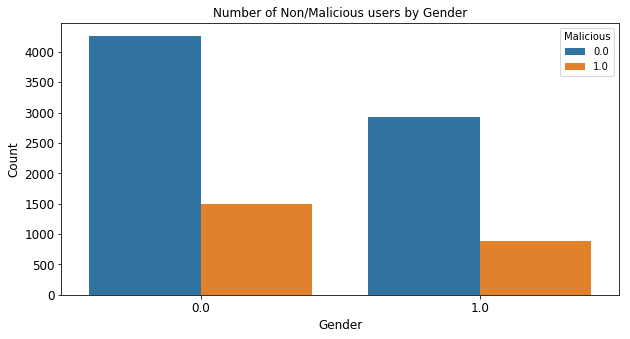

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(x='Gender',data=df2,hue='Malicious')
plt.xticks(size=12)
plt.xlabel('Gender',size=12)
plt.yticks(size=12)
plt.ylabel('Count',size=12)
plt.title('Number of Non/Malicious users by Gender')
plt.show()

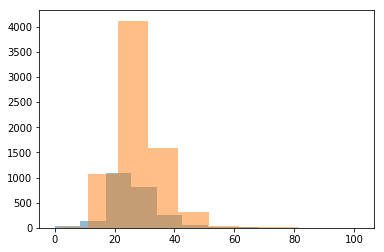

In [9]:
plt.hist(df2[df2['Malicious']==1]['Age'],alpha=0.5,bins=10)
plt.hist(df2[df2['Malicious']==0]['Age'],alpha=0.5,bins=10)
plt.show()

In [10]:
### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    display(cm)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid_acc(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='accuracy',cv=kfold,n_jobs=-1)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test    

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy on test data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

In [11]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [12]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,20,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4997     0     4997
True           0  1698     1698
__all__     4997  1698     6695

Accuracy of the  KNN  model for test data is: 0.8679442508710802

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2150    38     2188
True         341   341      682
__all__     2491   379     2870

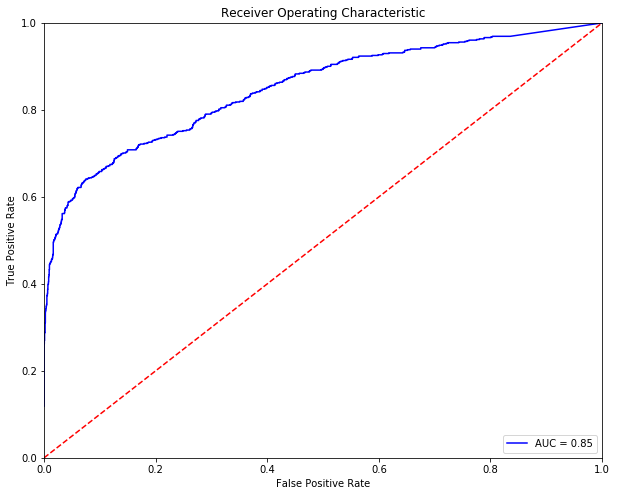

Optimal Threshold is 0.17071840700501725
Accuracy on test data is: 0.751567944250871


Predicted  False  True  __all__
Actual                         
False       1645   543     2188
True         170   512      682
__all__     1815  1055     2870

In [14]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [15]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [16]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.5,False,True,0.5,10000,ovr,l2,newton-cg,1e-05


Accuracy of the  Logistic  model for the training data is: 0.8306198655713218

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4802   195     4997
True         939   759     1698
__all__     5741   954     6695

Accuracy of the  Logistic  model for test data is: 0.8337979094076655

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2098    90     2188
True         387   295      682
__all__     2485   385     2870

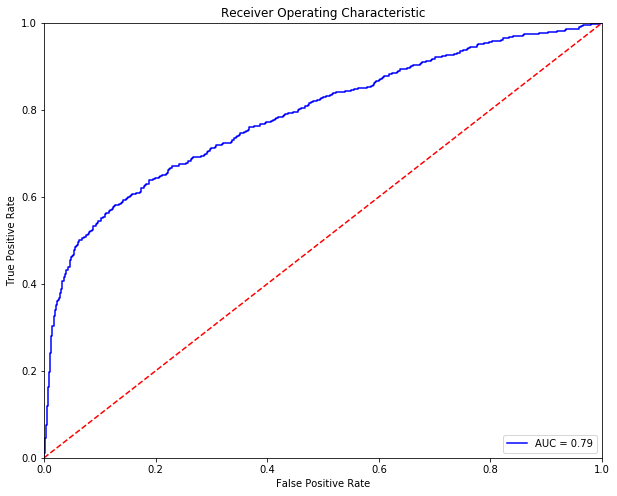

Optimal Threshold is 0.22737554079649955
Accuracy on test data is: 0.705226480836237


Predicted  False  True  __all__
Actual                         
False       1544   644     2188
True         202   480      682
__all__     1746  1124     2870

In [17]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [18]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [19]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,entropy,10,auto,10,0.1,10,10,0.1,500,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.8442120985810306

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4997     0     4997
True        1043   655     1698
__all__     6040   655     6695

Accuracy of the  Random Forest Trees  model for test data is: 0.8515679442508711

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2188     0     2188
True         426   256      682
__all__     2614   256     2870

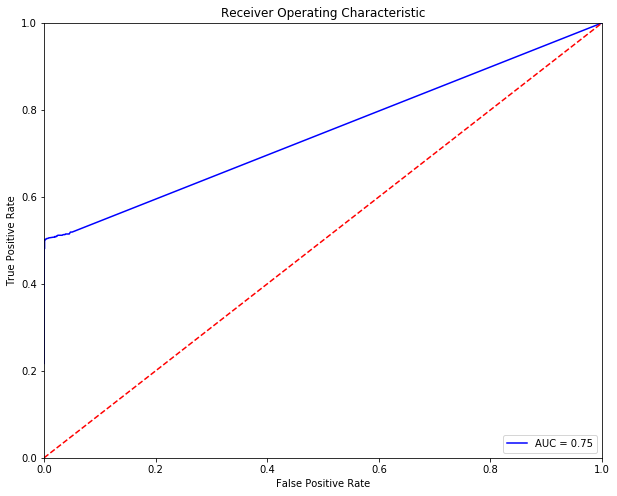

Optimal Threshold is 0.2003542737370254
Accuracy on test data is: 0.8498257839721254


Predicted  False  True  __all__
Actual                         
False       2085   103     2188
True         328   354      682
__all__     2413   457     2870

In [20]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [21]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

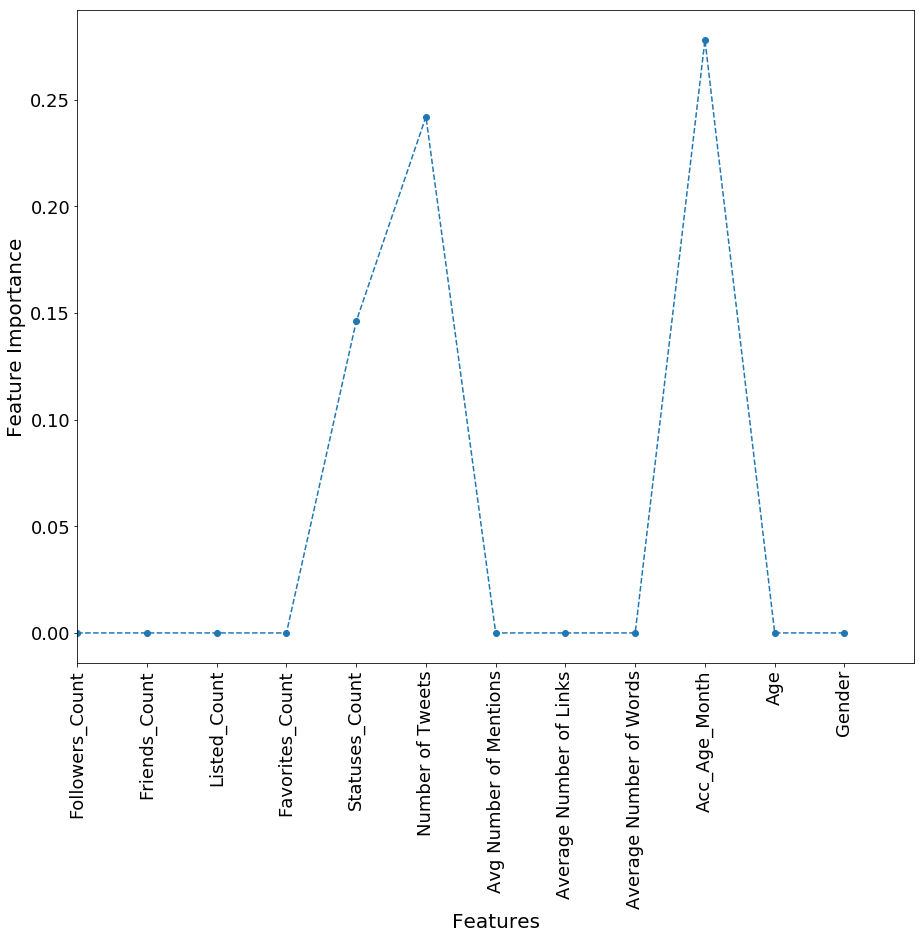

In [22]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [23]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME.R,0.5,150,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.9061986557132188

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4916    81     4997
True         547  1151     1698
__all__     5463  1232     6695

Accuracy of the  AdaBoostClassifier  model for test data is: 0.8982578397212544

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2138    50     2188
True         242   440      682
__all__     2380   490     2870

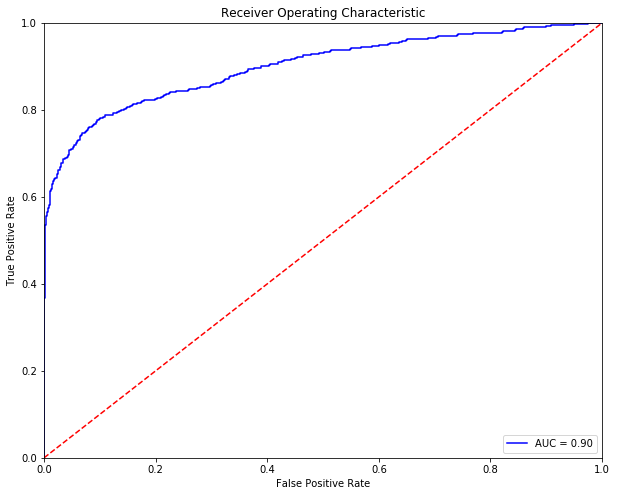

Optimal Threshold is 0.49440475648386956
Accuracy on test data is: 0.8219512195121951


Predicted  False  True  __all__
Actual                         
False       1799   389     2188
True         122   560      682
__all__     1921   949     2870

In [24]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [25]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

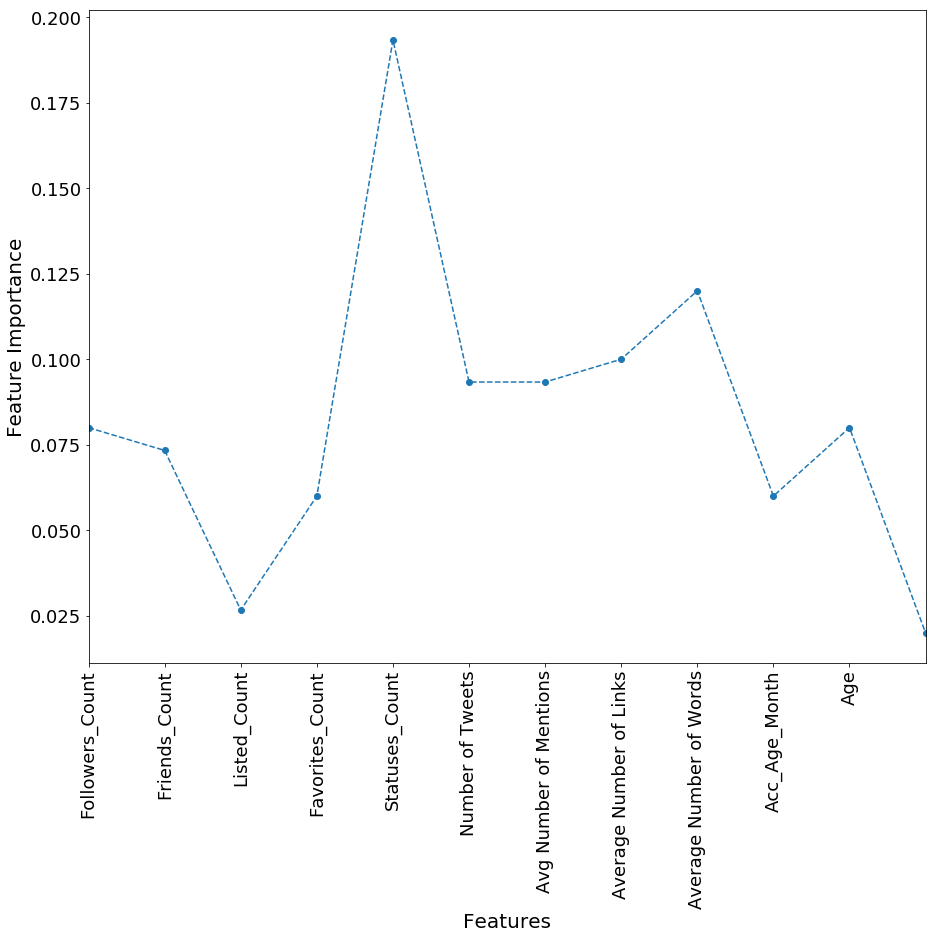

In [26]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [27]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,exponential,20,0.1,150,0,0.5


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.911277072442121

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4913    84     4997
True         510  1188     1698
__all__     5423  1272     6695

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.9003484320557491

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2131    57     2188
True         229   453      682
__all__     2360   510     2870

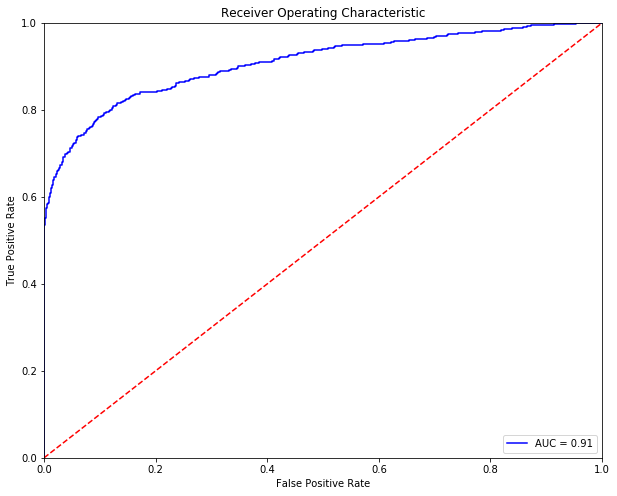

Optimal Threshold is 0.15493209730406887
Accuracy on test data is: 0.8358885017421602


Predicted  False  True  __all__
Actual                         
False       1830   358     2188
True         113   569      682
__all__     1943   927     2870

In [28]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [29]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

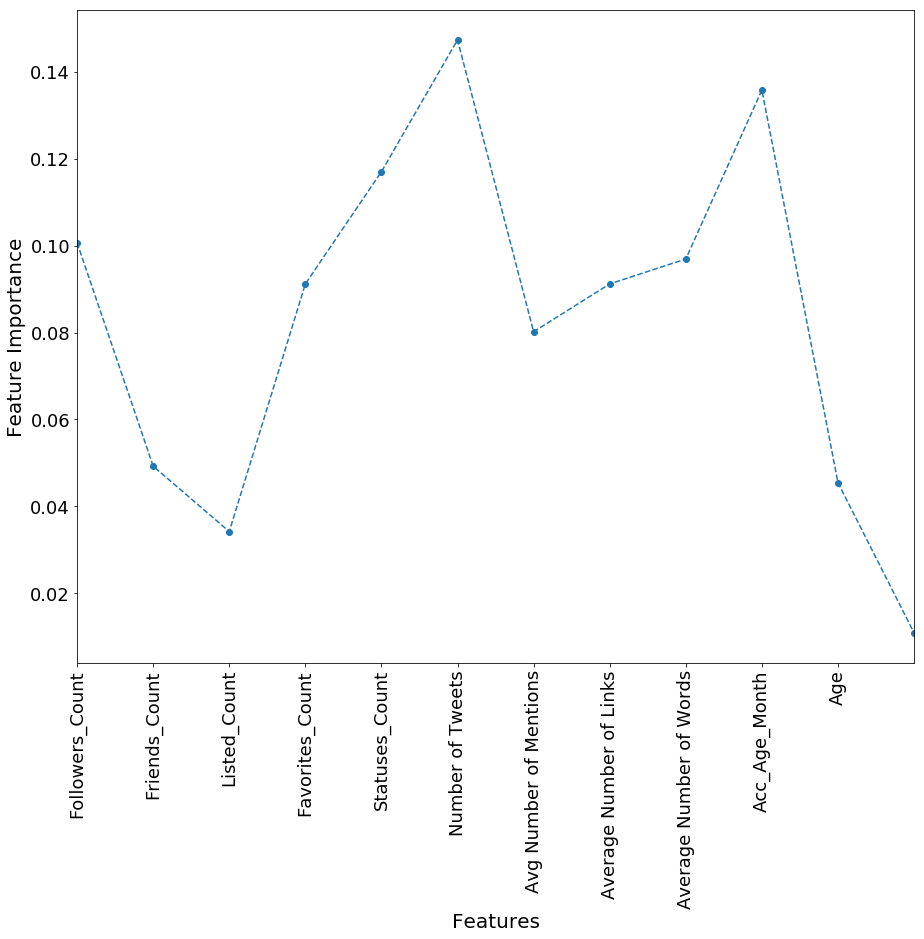

In [30]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [31]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,entropy,20,auto,0.001,5,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8948469006721433

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4847   150     4997
True         554  1144     1698
__all__     5401  1294     6695

Accuracy of the  Extra Decision Tree  model for test data is: 0.8874564459930313

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2111    77     2188
True         246   436      682
__all__     2357   513     2870

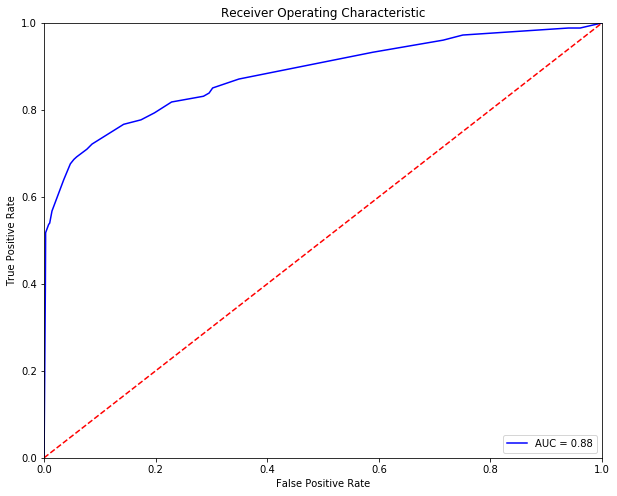

Optimal Threshold is 0.20437956204379562
Accuracy on test data is: 0.8146341463414634


Predicted  False  True  __all__
Actual                         
False       1808   380     2188
True         152   530      682
__all__     1960   910     2870

In [32]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [33]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

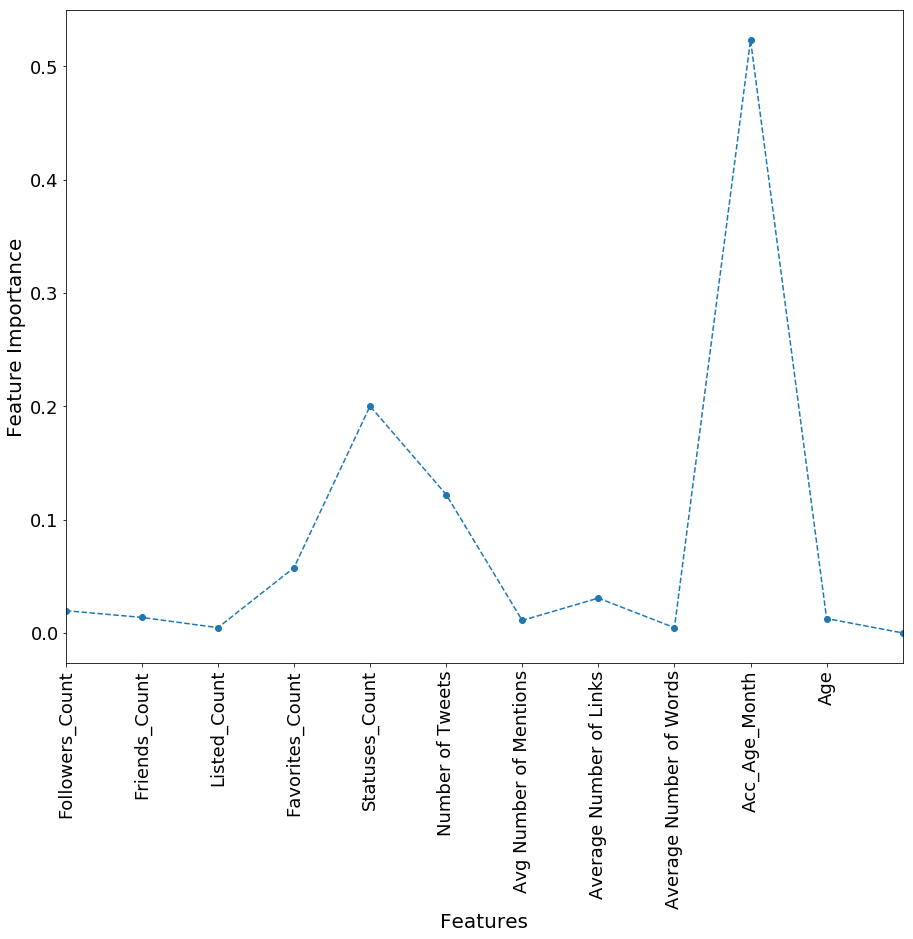

In [34]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 11])
plt.xticks(np.arange(11),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [35]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.3,300,True,0


Accuracy of the  Bagging  model for the training data is: 0.9293502613890964

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       4997     0     4997
True         473  1225     1698
__all__     5470  1225     6695

Accuracy of the  Bagging  model for test data is: 0.8972125435540069

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       2169    19     2188
True         276   406      682
__all__     2445   425     2870

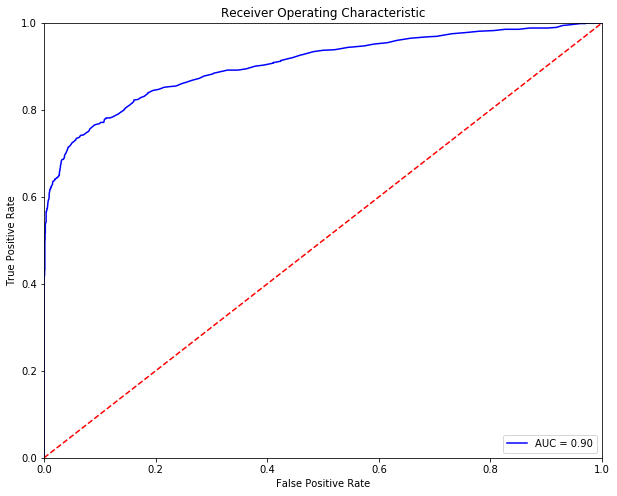

Optimal Threshold is 0.22
Accuracy on test data is: 0.8299651567944251


Predicted  False  True  __all__
Actual                         
False       1820   368     2188
True         120   562      682
__all__     1940   930     2870

In [36]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [37]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [38]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9368185212845407


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       4995     2     4997
True         421  1277     1698
__all__     5416  1279     6695

The test accuracy is: 0.8951219512195122


Predicted  False  True  __all__
Actual                         
False       2148    40     2188
True         261   421      682
__all__     2409   461     2870

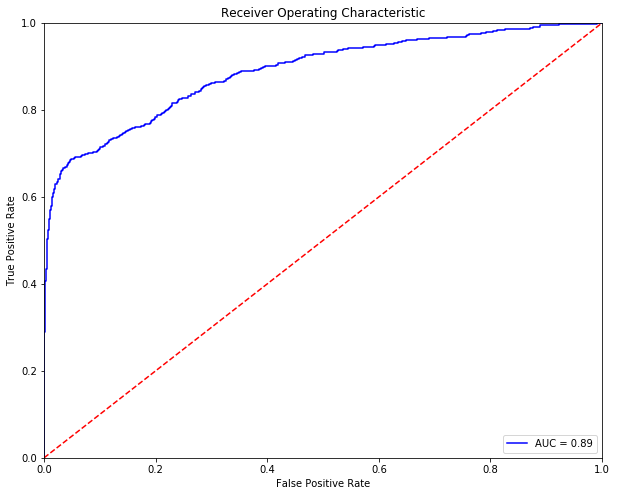

Optimal Threshold is 0.2525877750475117
Accuracy on test data is: 0.7898954703832752


Predicted  False  True  __all__
Actual                         
False       1729   459     2188
True         144   538      682
__all__     1873   997     2870

In [39]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [40]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [41]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=12))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.9359223301059902


Predicted  False  True  __all__
Actual                         
False       4926    71     4997
True         358  1340     1698
__all__     5284  1411     6695

The accuracy of the model on test data is: 0.8853658536585366


Predicted  False  True  __all__
Actual                         
False       2097    91     2188
True         238   444      682
__all__     2335   535     2870

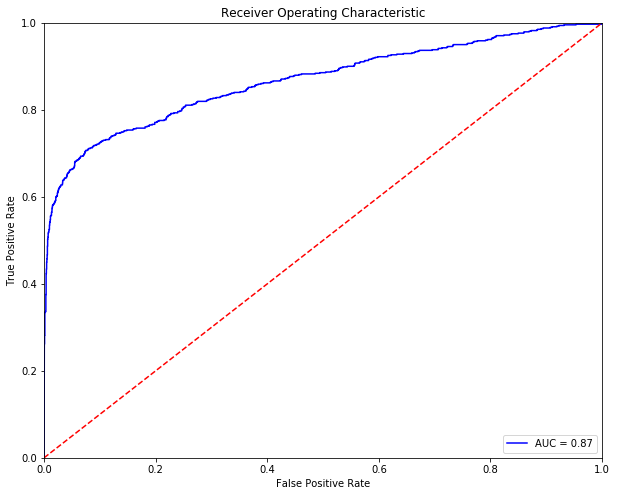

Optimal Threshold is 0.16681929
Accuracy of Logistic Model on training data is: 0.7808362369337979


Predicted  False  True  __all__
Actual                         
False       1709   479     2188
True         150   532      682
__all__     1859  1011     2870

In [42]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [43]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [44]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=12))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.1min finished


The accuracy of the model on training data is: 0.8536221060492906


Predicted  False  True  __all__
Actual                         
False       4840   157     4997
True         823   875     1698
__all__     5663  1032     6695

The accuracy of the model on test data is: 0.8522648083623693


Predicted  False  True  __all__
Actual                         
False       2111    77     2188
True         347   335      682
__all__     2458   412     2870

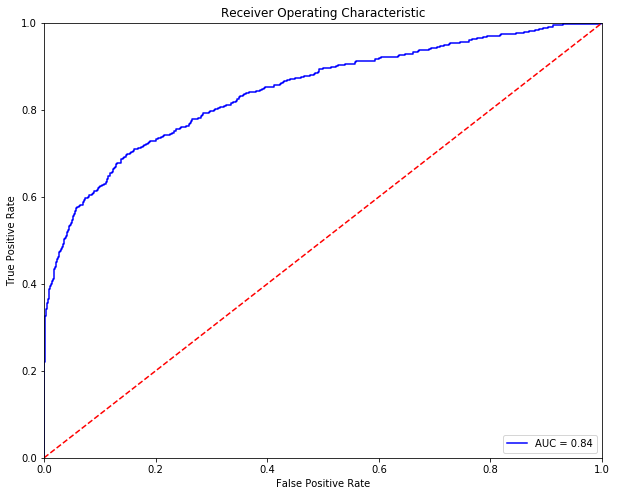

Optimal Threshold is 0.2105638
Accuracy on test data is: 0.756794425087108


Predicted  False  True  __all__
Actual                         
False       1656   532     2188
True         166   516      682
__all__     1822  1048     2870

In [45]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [46]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [47]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1698.0,4997.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.830620,759.0,4802.0,195.0,939.0,0.039023,0.553004
RandomForestClassifier,0.844212,655.0,4997.0,0.0,1043.0,0.000000,0.614252
AdaBoostClassifier,0.906199,1151.0,4916.0,81.0,547.0,0.016210,0.322144
GradientBoostingClassifier,0.911277,1188.0,4913.0,84.0,510.0,0.016810,0.300353
ExtraTreeClassifier,0.894847,1144.0,4847.0,150.0,554.0,0.030018,0.326266
BaggingClassifier,0.929350,1225.0,4997.0,0.0,473.0,0.000000,0.278563
VotingClassifier,0.936819,1277.0,4995.0,2.0,421.0,0.000400,0.247939
Neural Network-1,0.935922,1340.0,4926.0,71.0,358.0,0.014209,0.210836


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.867944,341.0,2150.0,38.0,341.0,0.017367,0.500000
LogisticRegression,0.833798,295.0,2098.0,90.0,387.0,0.041133,0.567449
RandomForestClassifier,0.851568,256.0,2188.0,0.0,426.0,0.000000,0.624633
AdaBoostClassifier,0.898258,440.0,2138.0,50.0,242.0,0.022852,0.354839
GradientBoostingClassifier,0.900348,453.0,2131.0,57.0,229.0,0.026051,0.335777
ExtraTreeClassifier,0.887456,436.0,2111.0,77.0,246.0,0.035192,0.360704
BaggingClassifier,0.897213,406.0,2169.0,19.0,276.0,0.008684,0.404692
VotingClassifier,0.895122,421.0,2148.0,40.0,261.0,0.018282,0.382698
Neural Network-1,0.885366,444.0,2097.0,91.0,238.0,0.041590,0.348974


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.751568,512.0,1645.0,543.0,170.0,0.248172,0.249267,0.170718,0.849369
LogisticRegression,0.705226,480.0,1544.0,644.0,202.0,0.294333,0.296188,0.227376,0.786162
RandomForestClassifier,0.849826,354.0,2085.0,103.0,328.0,0.047075,0.480938,0.200354,0.746978
AdaBoostClassifier,0.821951,560.0,1799.0,389.0,122.0,0.177788,0.178886,0.494405,0.899629
GradientBoostingClassifier,0.835889,569.0,1830.0,358.0,113.0,0.163620,0.165689,0.154932,0.907782
ExtraTreeClassifier,0.814634,530.0,1808.0,380.0,152.0,0.173675,0.222874,0.204380,0.880857
BaggingClassifier,0.829965,562.0,1820.0,368.0,120.0,0.168190,0.175953,0.220000,0.904917
VotingClassifier,0.789895,538.0,1729.0,459.0,144.0,0.209781,0.211144,0.252588,0.887438
Neural Network-1,0.780836,532.0,1709.0,479.0,150.0,0.218921,0.219941,0.166819,0.866561
